# Preprocess data for machine learning

### February 22, 2018
### Tiffany Huang

In [23]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

# Input data files are available in the "WDataFiles/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "WDataFiles"]).decode("utf8"))

WCities.csv
WGameCities.csv
WNCAATourneyCompactResults.csv
WNCAATourneySeeds.csv
WNCAATourneySlots.csv
WRegularSeasonCompactResults.csv
WSampleSubmissionStage1.csv
WSeasons.csv
WTeamSpellings.csv
WTeams.csv



# Load the Training Data

In [34]:
data_dir = 'WDataFiles/'
df_seeds = pd.read_csv(data_dir + 'WNCAATourneySeeds.csv')
df_tourney = pd.read_csv(data_dir + 'WNCAATourneyCompactResults.csv')
df_reg_season = pd.read_csv(data_dir + 'WRegularSeasonCompactResults.csv')

In [35]:
df_seeds.head()

,Season,Seed,TeamID
0,1998,W01,3330
1,1998,W02,3163
2,1998,W03,3112
3,1998,W04,3301
4,1998,W05,3272


In [36]:
df_tourney.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1998,137,3104,94,3422,46,H,0
1,1998,137,3112,75,3365,63,H,0
2,1998,137,3163,93,3193,52,H,0
3,1998,137,3198,59,3266,45,H,0
4,1998,137,3203,74,3208,72,A,0


In [37]:
df_reg_season.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1998,18,3104,91,3202,41,H,0
1,1998,18,3163,87,3221,76,H,0
2,1998,18,3222,66,3261,59,H,0
3,1998,18,3307,69,3365,62,H,0
4,1998,18,3349,115,3411,35,H,0


In [38]:
# First, we'll simplify the datasets to remove the columns we won't be using 
# and convert the seedings to the needed format (stripping the regional abbreviation in front of the seed).

# Get just the digits from the seeding. Return as int
def seed_to_int(seed):
    s_int = int(seed[1:3])
    return s_int
df_seeds['seed_int'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label
df_seeds.head()

,Season,TeamID,seed_int
0,1998,3330,1
1,1998,3163,2
2,1998,3112,3
3,1998,3301,4
4,1998,3272,5


In [39]:
df_tourney.drop(labels=['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], inplace=True, axis=1)
df_tourney.head()

,Season,WTeamID,LTeamID
0,1998,3104,3422
1,1998,3112,3365
2,1998,3163,3193
3,1998,3198,3266
4,1998,3203,3208


In [40]:
df_reg_season.drop(labels=['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], inplace=True, axis=1)
df_reg_season.head()

,Season,WTeamID,LTeamID
0,1998,3104,3202
1,1998,3163,3221
2,1998,3222,3261
3,1998,3307,3365
4,1998,3349,3411


In [43]:
# Find the record during the regular season between two teams
def regSeasonToRecord(df):
    record_dict = {}
    for index, row in df.iterrows():
        if ((row['WTeamID'], row['LTeamID']) in record_dict):
            record_dict[(row['WTeamID'], row['LTeamID'])] += 1
        else:
            record_dict[(row['WTeamID'], row['LTeamID'])] = 1
    return record_dict

In [41]:
# Merge the Seeds with their corresponding TeamIDs in the compact results dataframe.
df_winseeds = df_seeds.rename(columns={'TeamID':'WTeamID', 'seed_int':'WSeed'})
df_lossseeds = df_seeds.rename(columns={'TeamID':'LTeamID', 'seed_int':'LSeed'})
df_dummy = pd.merge(left=df_tourney, right=df_winseeds, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season', 'LTeamID'])
df_concat['SeedDiff'] = df_concat.WSeed - df_concat.LSeed
df_concat.head()

,Season,WTeamID,LTeamID,WSeed,LSeed,SeedDiff
0,1998,3104,3422,2,15,-13
1,1998,3112,3365,3,14,-11
2,1998,3163,3193,2,15,-13
3,1998,3198,3266,7,10,-3
4,1998,3203,3208,10,7,3


In [ ]:
# Add the record between the winning and losing teams to the table
record = regSeasonToRecord(df_reg_season)
# Iterate through df_concat rows, look for record in dictionary between WTeam and LTeam and add it to the row

In [42]:
# Now we'll create a dataframe that summarizes wins & losses along with 
# their corresponding seed differences. This is the meat of what we'll be creating our model on.
df_wins = pd.DataFrame()
df_wins['SeedDiff'] = df_concat['SeedDiff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['SeedDiff'] = -df_concat['SeedDiff']
df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,SeedDiff,Result
0,-13,1
1,-11,1
2,-13,1
3,-3,1
4,3,1


In [12]:
X_train = df_predictions.SeedDiff.values.reshape(-1,1)
y_train = df_predictions.Result.values
X_train, y_train = shuffle(X_train, y_train)

# Train the Model

In [13]:
# Use a basic logistic regression to train the model. You can set different C values to see how performance changes.
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.4568, with best C: 0.1


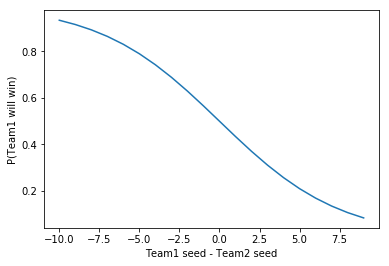

In [24]:
X = np.arange(-10, 10).reshape(-1, 1)
preds = clf.predict_proba(X)[:,1]

plt.figure()
plt.plot(X, preds)
plt.xlabel('Team1 seed - Team2 seed')
plt.ylabel('P(Team1 will win)')

In [20]:
df_sample_sub = pd.read_csv(data_dir + 'WSampleSubmissionStage1.csv')
n_test_games = len(df_sample_sub)

def get_year_t1_t2(ID):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in ID.split('_'))

In [21]:
X_test = np.zeros(shape=(n_test_games, 1))
for ii, row in df_sample_sub.iterrows():
    year, t1, t2 = get_year_t1_t2(row.ID)
    t1_seed = df_seeds[(df_seeds.TeamID == t1) & (df_seeds.Season == year)].seed_int.values[0]
    t2_seed = df_seeds[(df_seeds.TeamID == t2) & (df_seeds.Season == year)].seed_int.values[0]
    diff_seed = t1_seed - t2_seed
    X_test[ii, 0] = diff_seed

In [22]:
preds = clf.predict_proba(X_test)[:,1]

clipped_preds = np.clip(preds, 0.05, 0.95)
df_sample_sub.Pred = clipped_preds
df_sample_sub.head()

,ID,Pred
0,2014_3103_3107,0.629367
1,2014_3103_3113,0.257500
2,2014_3103_3119,0.500000
3,2014_3103_3124,0.051551
4,2014_3103_3140,0.434196


In [ ]:
# Create submission file!
df_sample_sub.to_csv('logreg_seed_starter.csv', index=False)